In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv003.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids='0006', xarray_dir='../data/NAFLD_test')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-11-7.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
cohort.eval_baseline()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD_test/0006/t1_pre_in.nc
Loading ../data/NAFLD_test/0006/t1_pre_water.nc
Loading ../data/NAFLD_test/0006/t1_pre_out.nc
Loading ../data/NAFLD_test/0006/t1_pre_fat.nc
Loading ../data/NAFLD_test/0006/t2.nc
Loading ../data/NAFLD_test/0006/mre_raw.nc
Loading ../data/NAFLD_test/0006/wave.nc
Loading ../data/NAFLD_test/0006/mre.nc
Loading ../data/NAFLD_test/0006/anat_mask.nc
Loading ../data/NAFLD_test/0006/mre_mask.nc
  0%|          | 0/1 [00:00<?, ?it/s]

  return key in self.data

  return key in self.data



100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


In [4]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [17]:
%autoreload

pino = mre_pinn.model.pino.HyperCNN(
    n_channels_in=4,
    n_channels_block=16,
    n_conv_per_block=1,
    n_conv_blocks=8,
    width_factor=2,
    activ_fn='g',
    n_latent=1024,
    n_spatial_freqs=128,
    u_omega=15/300,
    u_scale=1e2,
    mu_omega=15/300,
    mu_scale=5e2,
    skip_connect=True,
    dense=True
)
pino

HyperCNN(
  (cnn): CNN(
    (conv_in): Conv3d(4, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_block0): ConvBlock(
      (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool0): AvgPool3d(kernel_size=2, stride=2, padding=0)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool1): AvgPool3d(kernel_size=2, stride=2, padding=0)
    (conv_block2): ConvBlock(
      (conv0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool2): AvgPool3d(kernel_size=2, stride=2, padding=0)
    (conv_block3): ConvBlock(
      (conv0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool3): AvgPool3d(kernel_size=2, stride=2, padding=0)
    (conv_block4): ConvBlock(
      (conv0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool4): AvgPool3d(kernel_size=(

In [18]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-5,
    loss_weights=[1e0, 1e0],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000292 s



Training model...

0         [2.55e+04, 1.64e+06]    [2.55e+04, 1.64e+06]    []  
h	8.381903171539307e-09	1.00048828125


<IPython.core.display.Javascript object>


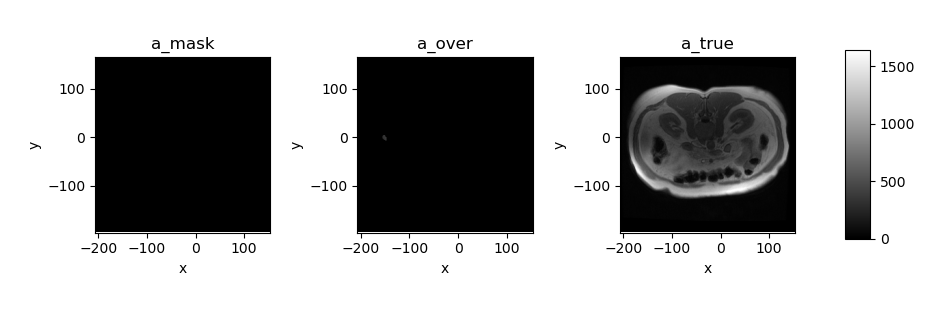

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


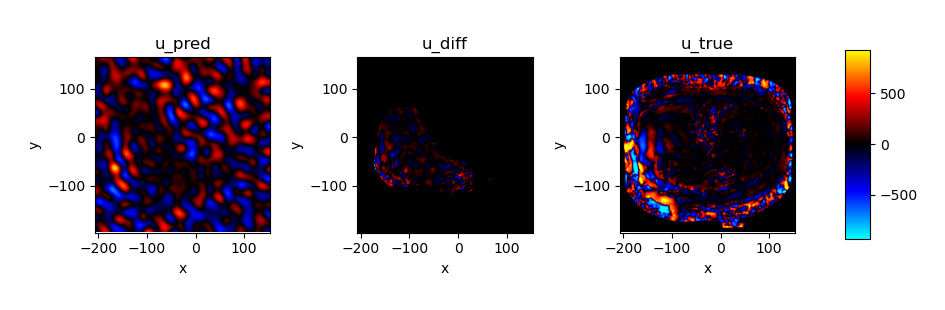

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


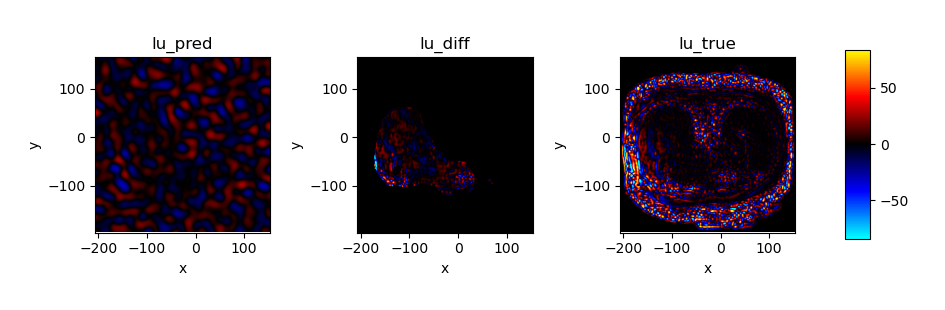

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


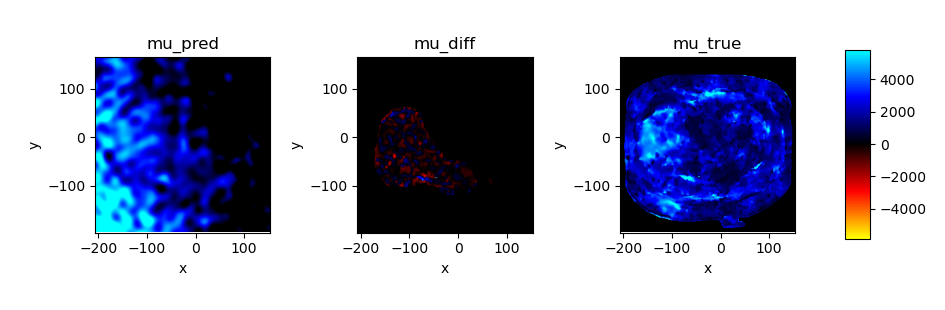

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

Time spent testing: 44.12%
10        [2.02e+04, 5.11e+05]    [2.02e+04, 5.11e+05]    []  
h	-2.26777046918869e-06	1.0005054473876953
Time spent testing: 40.24%
20        [1.38e+04, 2.32e+05]    [1.38e+04, 2.32e+05]    []  
h	-2.9276125133037567e-06	1.0005075931549072
Time spent testing: 38.76%
30        [8.90e+03, 1.46e+05]    [8.90e+03, 1.46e+05]    []  
h	-2.7865171432495117e-06	1.0005067586898804
Time spent testing: 37.93%
40        [6.44e+03, 9.90e+04]    [6.44e+03, 9.90e+04]    []  
h	-2.991408109664917e-06	1.000506043434143
Time spent testing: 37.42%
50        [5.18e+03, 8.61e+04]    [5.18e+03, 8.61e+04]    []  
h	-2.8801150619983673e-06	1.0005055665969849
Time spent testing: 37.07%
60        [4.29e+03, 7.92e+04]    [4.29e+03, 7.92e+04]    []  
h	-3.0403025448322296e-06	1.0005054473876953
Time spent testing: 36.81%
70        [3.59e+03, 6.63e+04]    [3.59e+03, 6.63e+04]    []  
h	-3.3797696232795715e-06	1.000504732131958
Time spent testing: 36.61%
80        [3.11e+03, 5.97e+04]   


KeyboardInterrupt



In [19]:
torch.backends.cudnn.enabled = False
model.train(10000, display_every=10, callbacks=[test_eval])